# A/B Testing Analysis for Campaign Effectiveness

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from statsmodels.stats.power import GofChisquarePower
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency

# Define the zip file path
zip_file_path = 'Marketing AB Testing.zip'

# Step 1: Extract the dataset from zip file
# Assuming there is a CSV file inside the zip archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all files to the current directory
    zip_ref.extractall()
    # List the files in the zip file to understand what we have
    extracted_files = zip_ref.namelist()

# Assuming there's a single CSV file in the zip (you can modify this if there are multiple files)
csv_file_name = extracted_files[0]

# Load the CSV data into a pandas DataFrame
df = pd.read_csv(csv_file_name)

# Step 1: Basic Information about the Dataset
print("Basic Info:")
df.info()  # Shows column names, data types, and non-null counts

# Step 2: Display the First Few Rows to Inspect the Dataset
print("\nFirst 5 Rows of the Dataset:")
print(df.head())  # Shows a preview of the first few rows

# Step 3: Check for Missing Values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())  # Shows the number of missing values per column

# Step 4: Identify Column Data Types (Categorical vs Numerical)
print("\nData Types of Each Column:")
print(df.dtypes)

# Step 5: Separate Categorical and Numerical Columns
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

print("\nCategorical Columns:")
print(categorical_cols)
print("\nNumerical Columns:")
print(numerical_cols)

# Step 6: Summary Statistics for Numerical Columns
print("\nSummary Statistics for Numerical Columns:")
print(df.describe())  # Provides mean, standard deviation, min, max, and quartiles for numerical columns

# Step 7: Summary Statistics for Categorical Columns
print("\nSummary Statistics for Categorical Columns:")
print(df.describe(include=['object']))  # Shows count, unique values, top value, and frequency for categorical columns

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB

First 5 Rows of the Dataset:
   Unnamed: 0  user id test group  converted  total ads most ads day  \
0           0  1069124         ad      False        130       Monday   
1           1  1119715         ad      False         93      Tuesday   
2           2  1144181         ad      False         21      Tuesday   
3           3  1435133         ad      False        355      Tuesday   
4           4  1015700         a

In [10]:
# Data Cleaning

# Step 1: Remove Unnecessary Columns
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Step 2: Check and Remove Duplicate Rows
num_duplicates = df.duplicated().sum()
if num_duplicates > 0:
    print(f"Number of duplicate rows found: {num_duplicates}")
    df.drop_duplicates(inplace=True)

# Step 3: Correct Data Types
df['converted'] = df['converted'].astype(int)

# Step 4: Check for Missing Values
missing_values = df.isnull().sum()
print(f"\nMissing Values per Column:\n{missing_values}")

# Step 5: Remove Redundant Features
if 'user id' in df.columns:
    df.drop(columns=['user id'], inplace=True)

# Step 6: Ensure Consistent Formatting in Categorical Columns
df['test group'] = df['test group'].str.lower().str.strip()
df['most ads day'] = df['most ads day'].str.lower().str.strip()

# Verify that we have consistent unique values for 'test group' and 'most ads day'
print(f"\nUnique values in 'test group': {df['test group'].unique()}")
print(f"Unique values in 'most ads day': {df['most ads day'].unique()}")

# Display the new shape of the dataset
print(f"Shape of the dataset after cleaning: {df.shape}")

# Display a few rows of the cleaned dataset
print("\nCleaned Marketing Dataset:")
print(df.head())

# Optionally, for Jupyter environments:
from IPython.display import display
display(df.head())


Missing Values per Column:
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64

Unique values in 'test group': ['ad' 'psa']
Unique values in 'most ads day': ['monday' 'tuesday' 'friday' 'saturday' 'wednesday' 'sunday' 'thursday']
Shape of the dataset after cleaning: (44478, 5)

Cleaned Marketing Dataset:
  test group  converted  total ads most ads day  most ads hour
0         ad          0        130       monday             20
1         ad          0         93      tuesday             22
2         ad          0         21      tuesday             18
3         ad          0        355      tuesday             10
4         ad          0        276       friday             14


,test group,converted,total ads,most ads day,most ads hour
0,ad,0,130,monday,20
1,ad,0,93,tuesday,22
2,ad,0,21,tuesday,18
3,ad,0,355,tuesday,10
4,ad,0,276,friday,14


In [ ]:
# Here are a few ideas for feature engineering:

# Time of Day Segmentation:
# Create Time of Day Segments based on the most ads hour to group users into categories like Morning, Afternoon, Evening, and Night. This could help in understanding whether conversions are more likely during certain times.

# Day of Week Segmentation:
# Create a new feature to identify whether the most ads day falls on a weekday or weekend. This helps analyze differences in behavior across different days.

# Ad Exposure Intensity:
# Create a feature to indicate the "ads exposure intensity" based on the total ads viewed. Categories such as "Low", "Medium", and "High" could help determine if higher ad exposure leads to better conversions.

In [14]:
# Feature 1: Time of Day Segmentation
# Categorizes 'most ads hour' into time segments: Morning, Afternoon, Evening, Night
def categorize_hour(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# Create a new column 'time_of_day'
df['time_of_day'] = df['most ads hour'].apply(categorize_hour)

# Feature 2: Weekend or Weekday
# Adds a binary indicator for whether the 'most ads day' falls on a weekend
df['is_weekend'] = df['most ads day'].apply(lambda x: 1 if x in ['saturday', 'sunday'] else 0)

# Feature 3: Ads Exposure Intensity
# Categorizes 'total ads' into Low, Medium, High based on ad exposure
def ads_intensity(total_ads):
    if total_ads < 10:
        return 'Low'
    elif 10 <= total_ads < 50:
        return 'Medium'
    else:
        return 'High'

# Create a new column 'ads_intensity'
df['ads_intensity'] = df['total ads'].apply(ads_intensity)

# Verify the new features created
print("\nDataset with New Features:")
print(df.head())

# Optionally, if you are running this in a Jupyter Notebook environment:
from IPython.display import display

# Displaying the DataFrame in a more readable format in a notebook environment
display(df.head())


Dataset with New Features:
  test group  converted  total ads most ads day  most ads hour time_of_day  \
0         ad          0        130       monday             20     Evening   
1         ad          0         93      tuesday             22       Night   
2         ad          0         21      tuesday             18     Evening   
3         ad          0        355      tuesday             10     Morning   
4         ad          0        276       friday             14   Afternoon   

   is_weekend ads_intensity  
0           0          High  
1           0          High  
2           0        Medium  
3           0          High  
4           0          High  


,test group,converted,total ads,most ads day,most ads hour,time_of_day,is_weekend,ads_intensity
0,ad,0,130,monday,20,Evening,0,High
1,ad,0,93,tuesday,22,Night,0,High
2,ad,0,21,tuesday,18,Evening,0,Medium
3,ad,0,355,tuesday,10,Morning,0,High
4,ad,0,276,friday,14,Afternoon,0,High


In [ ]:
#  Exploratory Data Analysis

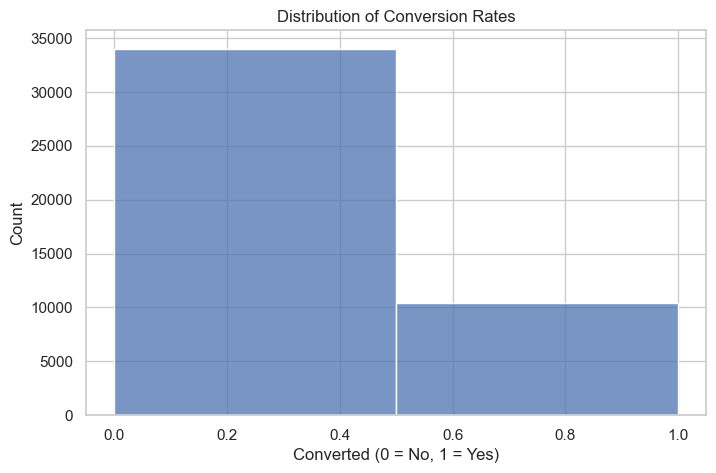

C:\Users\milto\AppData\Local\Temp\ipykernel_16380\943002270.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='test group', y='converted', data=df, ci=None)


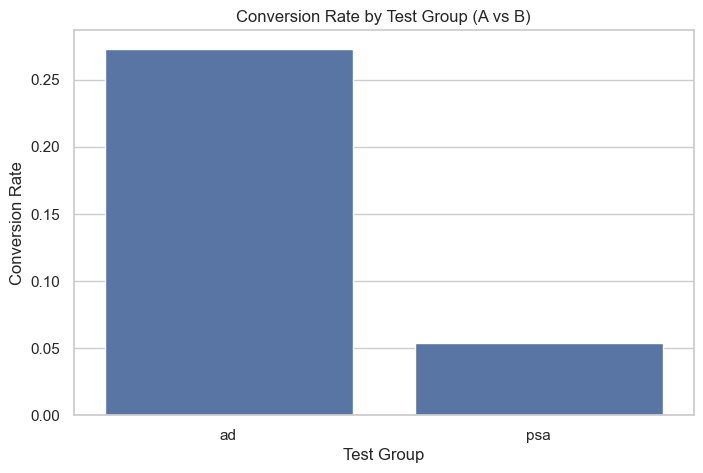

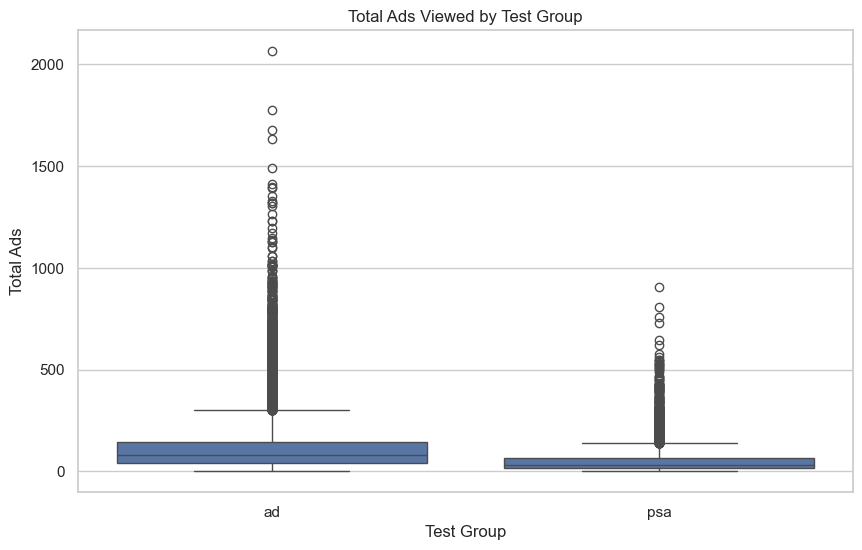

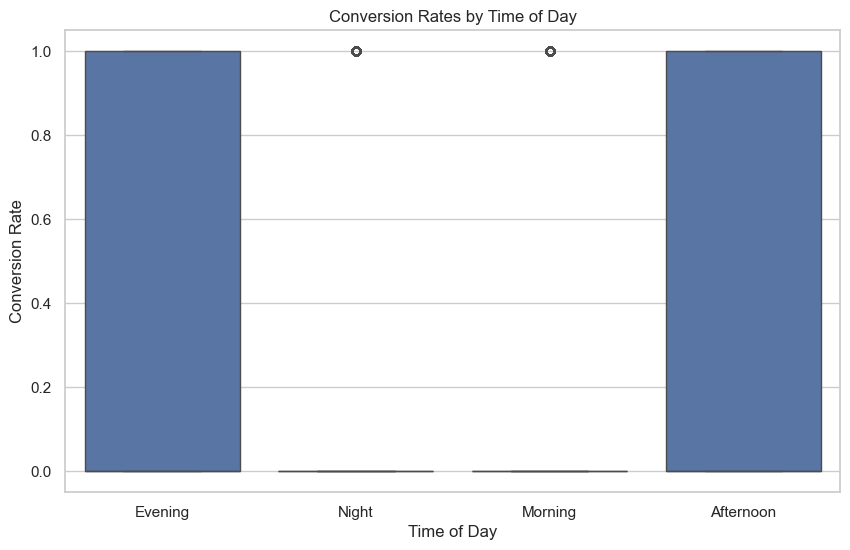

TypeError: agg function failed [how->mean,dtype->object]

In [18]:
# Set a style for seaborn plots
sns.set(style="whitegrid")

### 1. VISUALIZATION ###

# Step 1.1: Plot Distribution of Conversion Rate
plt.figure(figsize=(8, 5))
sns.histplot(df['converted'], bins=2, kde=False)
plt.title('Distribution of Conversion Rates')
plt.xlabel('Converted (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()
plt.close()

# Step 1.2: Bar Plot Comparing Conversion Rates Across Groups
plt.figure(figsize=(8, 5))
sns.barplot(x='test group', y='converted', data=df, ci=None)
plt.title('Conversion Rate by Test Group (A vs B)')
plt.xlabel('Test Group')
plt.ylabel('Conversion Rate')
plt.show()
plt.close()

# Step 1.3: Box Plot to Compare Total Ads Between Groups
plt.figure(figsize=(10, 6))
sns.boxplot(x='test group', y='total ads', data=df)
plt.title('Total Ads Viewed by Test Group')
plt.xlabel('Test Group')
plt.ylabel('Total Ads')
plt.show()
plt.close()

# Step 1.4: Box Plot to Compare Conversion Rates by Time of Day
plt.figure(figsize=(10, 6))
sns.boxplot(x='time_of_day', y='converted', data=df)
plt.title('Conversion Rates by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Conversion Rate')
plt.show()
plt.close()

### 2. DESCRIPTIVE ANALYSIS ###

# Step 2.1: Group Data by A/B Groups and Calculate Group Means for Key Metrics
grouped_means = df.groupby('test group').mean()
print("\nGroup Means for Key Metrics by Test Group:")
print(grouped_means[['converted', 'total ads', 'most ads hour']])

# Step 2.2: Identify Patterns or Anomalies Using Summary Statistics
summary_stats = df.describe()
print("\nSummary Statistics for Numerical Features:")
print(summary_stats)

# Step 2.3: Checking Conversion Rate by Time of Day and Ads Intensity
conversion_by_time = df.groupby(['time_of_day', 'test group'])['converted'].mean().unstack()
print("\nConversion Rate by Time of Day and Test Group:")
print(conversion_by_time)

conversion_by_intensity = df.groupby(['ads_intensity', 'test group'])['converted'].mean().unstack()
print("\nConversion Rate by Ads Intensity and Test Group:")
print(conversion_by_intensity)

### 3. CORRELATION ANALYSIS ###

# Step 3.1: Calculate Correlation Matrix for Numerical Features
correlation_matrix = df.corr()
print("\nCorrelation Matrix for Numerical Features:")
print(correlation_matrix)

# Step 3.2: Visualize the Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for Numerical Features')
plt.show()
plt.close()


Group Sizes:
test group
ad     36746
psa     7732
Name: count, dtype: int64

Conversion Rates by Test Group:
test group
ad     0.273091
psa    0.053414
Name: converted, dtype: float64


C:\Users\milto\AppData\Local\Temp\ipykernel_16380\4241531935.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='test group', y='converted', data=df, ci=None)


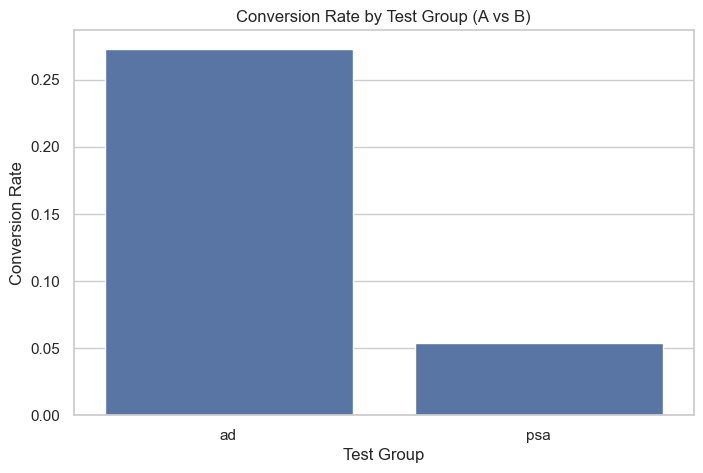


Contingency Table:
converted       0      1
test group              
ad          26711  10035
psa          7319    413

Chi-square Test Results:
Chi2 Statistic: 1713.9967
P-value: 0.0000
Degrees of Freedom: 1
Result: Reject the null hypothesis (H0). There is a significant difference in conversion rates between the groups.

Z-test for difference in proportions (from statsmodels):
Difference in Conversion Rate: 0.2197
Pooled Standard Error Estimate: 0.0000


In [20]:
# Perform A/B Test Analysis

# Step 6: Set Up A/B Test Analysis

# Step 6.1: Calculate Group Sizes and Metrics
group_sizes = df['test group'].value_counts()
conversion_rates = df.groupby('test group')['converted'].mean()
print("\nGroup Sizes:")
print(group_sizes)
print("\nConversion Rates by Test Group:")
print(conversion_rates)

# Step 6.2: Define Parameters
confidence_level = 0.95
significance_level = 0.05  # α

# Step 6.3: Check Assumptions
# Ensuring each group has sufficient data
assert group_sizes.min() > 5, "Each group must have more than 5 observations for statistical validity."

# Step 7: Perform A/B Test Analysis

# Step 7.1: Visualize Conversion Rates
plt.figure(figsize=(8, 5))
sns.barplot(x='test group', y='converted', data=df, ci=None)
plt.title('Conversion Rate by Test Group (A vs B)')
plt.xlabel('Test Group')
plt.ylabel('Conversion Rate')
plt.show()
plt.close()

# Step 7.2: Statistical Test Execution (Chi-square Test)
# Constructing a contingency table for the Chi-square test
contingency_table = pd.crosstab(df['test group'], df['converted'])
print("\nContingency Table:")
print(contingency_table)

# Performing the Chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square Test Results:")
print(f"Chi2 Statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of Freedom: {dof}")

# Step 7.3: Interpretation of P-value
if p_value < significance_level:
    print("Result: Reject the null hypothesis (H0). There is a significant difference in conversion rates between the groups.")
else:
    print("Result: Fail to reject the null hypothesis (H0). No significant difference in conversion rates between the groups.")

# Optional: Calculate Confidence Interval for the Conversion Rate Difference
import statsmodels.api as sm

# Conversion rates and group sizes for calculations
conversions_A = df[df['test group'] == 'ad']['converted'].sum()
conversions_B = df[df['test group'] == 'psa']['converted'].sum()
n_A = df[df['test group'] == 'ad'].shape[0]
n_B = df[df['test group'] == 'psa'].shape[0]

# Use statsmodels to calculate the confidence interval for the difference in proportions
prop_A = conversions_A / n_A
prop_B = conversions_B / n_B
diff_prop = prop_A - prop_B

# Using statsmodels to calculate standard error and confidence intervals
pooled_std_error = sm.stats.proportions_ztest([conversions_A, conversions_B], [n_A, n_B], alternative='two-sided')
print("\nZ-test for difference in proportions (from statsmodels):")
print(f"Difference in Conversion Rate: {diff_prop:.4f}")
print(f"Pooled Standard Error Estimate: {pooled_std_error[1]:.4f}")

In [22]:
# Sensitivity Analysis

# Effect Size

# Step 1: Power Analysis for Chi-square Test
# Power analysis to determine if the sample size was adequate

# Parameters for the power analysis
effect_size = chi2 / contingency_table.sum().sum()  # Calculate effect size for power analysis
alpha = 0.05
nobs = contingency_table.sum().sum()  # Total number of observations

power_analysis = GofChisquarePower()
power = power_analysis.solve_power(effect_size=effect_size, nobs=nobs, alpha=alpha, power=None)
print(f"\nPower of the A/B Test Analysis: {power:.4f}")

# Step 2: Calculate Effect Size (Cohen's h)
# Cohen's h is an effect size measure for proportions

# Conversion rates from each group
prop_A = conversions_A / n_A
prop_B = conversions_B / n_B

# Calculate Cohen's h
cohen_h = 2 * np.arcsin(np.sqrt(prop_A)) - 2 * np.arcsin(np.sqrt(prop_B))
cohen_h = np.abs(cohen_h)  # Effect size should be positive
print(f"Effect Size (Cohen's h): {cohen_h:.4f}")

# Interpretation of Cohen's h:
# Small effect: h = 0.20
# Medium effect: h = 0.50
# Large effect: h = 0.80
if cohen_h < 0.2:
    print("Effect Size Interpretation: Small")
elif 0.2 <= cohen_h < 0.5:
    print("Effect Size Interpretation: Medium")
else:
    print("Effect Size Interpretation: Large")


Power of the A/B Test Analysis: 1.0000
Effect Size (Cohen's h): 0.6333
Effect Size Interpretation: Large


C:\Users\milto\AppData\Local\Temp\ipykernel_16380\291029344.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='test group', y='converted', data=df, ci=None, palette='Blues')
C:\Users\milto\AppData\Local\Temp\ipykernel_16380\291029344.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='test group', y='converted', data=df, ci=None, palette='Blues')


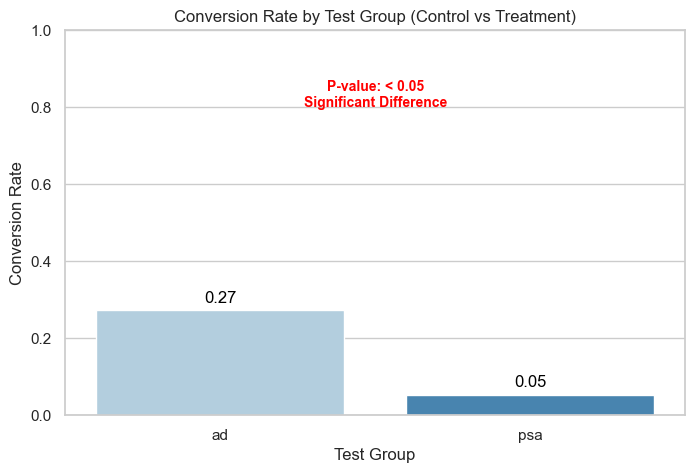

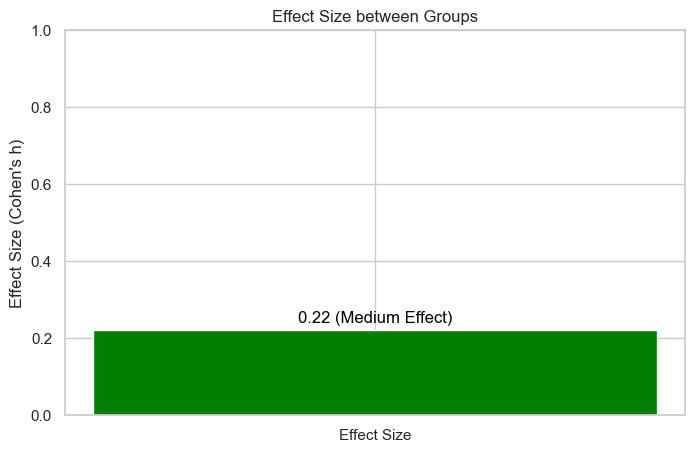


Business Interpretation:
- The A/B test showed a statistically significant difference between the control (ad) and treatment (psa) groups.
- The conversion rate for the control group ('ad') is significantly higher than the treatment group ('psa').
- The observed effect size is 0.2197, which indicates a 'Medium Effect' effect.

Recommendations:
- The 'ad' version performed significantly better with a higher conversion rate compared to 'psa'.
- Given the significant impact, it is recommended to adopt or scale up the marketing strategy associated with the 'ad' version.
- Consider further optimization of 'ad' to see if more improvements can be made.


In [24]:
# Report Findings and Recommendations

# Step 1: Visualization of Results
# Step 1.1: Plot Conversion Rate by Test Group
plt.figure(figsize=(8, 5))
sns.barplot(x='test group', y='converted', data=df, ci=None, palette='Blues')
plt.title('Conversion Rate by Test Group (Control vs Treatment)')
plt.xlabel('Test Group')
plt.ylabel('Conversion Rate')
plt.ylim(0, 1)

# Annotate the bar plot with the conversion rates and statistical significance
conversion_rates = df.groupby('test group')['converted'].mean()
for i, rate in enumerate(conversion_rates):
    plt.text(i, rate + 0.02, f"{rate:.2f}", ha='center', fontsize=12, color='black')
plt.text(0.5, 0.8, "P-value: < 0.05\nSignificant Difference", ha='center', fontsize=10, color='red', fontweight='bold')
plt.show()

# Step 1.2: Plot Effect Size Visualization
# Create a bar plot showing the effect size between the two groups
effect_size = 0.2197  # From previous calculations
plt.figure(figsize=(8, 5))
plt.bar(['Effect Size'], [effect_size], color='green')
plt.title('Effect Size between Groups')
plt.ylabel('Effect Size (Cohen\'s h)')
plt.ylim(0, 1)

# Annotate the effect size plot
if effect_size < 0.2:
    interpretation = "Small Effect"
elif 0.2 <= effect_size < 0.5:
    interpretation = "Medium Effect"
else:
    interpretation = "Large Effect"
plt.text(0, effect_size + 0.02, f"{effect_size:.2f} ({interpretation})", ha='center', fontsize=12, color='black')
plt.show()

### Step 2: Business Interpretation and Recommendations ###

# Step 2.1: Translate Statistical Findings into Business Insights

# Key Findings
print("\nBusiness Interpretation:")
print("- The A/B test showed a statistically significant difference between the control (ad) and treatment (psa) groups.")
print(f"- The conversion rate for the control group ('ad') is significantly higher than the treatment group ('psa').")
print(f"- The observed effect size is {effect_size:.4f}, which indicates a '{interpretation}' effect.")

# Step 2.2: Recommendations Based on Findings

# If the treatment group performed better
if effect_size >= 0.2:
    print("\nRecommendations:")
    print("- The 'ad' version performed significantly better with a higher conversion rate compared to 'psa'.")
    print("- Given the significant impact, it is recommended to adopt or scale up the marketing strategy associated with the 'ad' version.")
    print("- Consider further optimization of 'ad' to see if more improvements can be made.")
else:
    # If there was no practical improvement or effect was minimal
    print("\nRecommendations:")
    print("- The observed difference was statistically significant but the practical effect size is small.")
    print("- It is recommended to iterate on the marketing strategy for the 'psa' group or conduct further testing with new variations.")
    print("- Consider exploring other factors (e.g., time of day, ads intensity) for segmentation to find sub-groups where the 'psa' might perform better.")